In [38]:
import random
import math
import copy
import csv

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = {'legend.fontsize': 20,
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize':20,
         'xtick.labelsize': 20,
         'ytick.labelsize':20}

plt.rcParams.update(params)

In [2]:
# read example file
def read_example_file(filename):
    with open(filename) as fp:
        prob_setting = list(map(lambda x: int(x), fp.readline().split()))
        if len(prob_setting) == 1:
            n_targets, n_weapons = prob_setting[0], prob_setting[0]
        else:
            n_targets, n_weapons = prob_setting

        values = []
        for i in range(n_targets):
            values.append(float(fp.readline()))

        probabilities = []
        for i in range(n_weapons):
            probabilities.append([])
            for j in range(n_targets):
                probabilities[i].append(float(fp.readline()))
    return n_targets, n_weapons, values, probabilities

In [3]:
# check convergence
def check_convergence(population, threshold):
    assignment_dict = {}
    for assignment in population:
        assignment = tuple(assignment)
        if assignment not in assignment_dict:
            assignment_dict[assignment] = 0
        assignment_dict[assignment] += 1
    for assignment in assignment_dict:
        if assignment_dict[assignment] >= len(population) * threshold:
            return True
    return False

# DQN-related code

In [4]:
'''Take in n by m matrix, convert it to 1D feature vector '''
class DQN(nn.Module):
    def __init__(self, n, m, embedding_size=8, units=64):
        super(DQN, self).__init__()
        # The assignment becomes embedded, so it has size m * embedding_size
        # when flattened
        # The n comes from the values attached
        self.assignment_size = m * embedding_size
        self.input_size = self.assignment_size + n
        self.output_size = m * n
        self.n = n
        self.m = m
    
        self.embedding_size = embedding_size
        # Embed the targets, since the actual numerical value of the
        # targets don't mean anything
        # Another idea: skip the middleman and replace the targets
        # with the target values
        self.embedding = nn.Embedding(n, self.embedding_size)
        self.lin1 = nn.Linear(self.input_size, units)
        self.drop1 = nn.Dropout(0.2)
        self.lin2 = nn.Linear(units, self.output_size)
        self.drop2 = nn.Dropout(0.2)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        assignment = state[:, :self.m].long()
        assignment = self.embedding(assignment)
        
        values = state[:, self.m:].float()
                
        # Flatten the assignment embedding
        assignment = assignment.view(-1, self.assignment_size).float() 
        
        # and concatenate the values
        x = torch.cat([assignment, values], dim=1)
        
        x = F.relu(self.drop1(self.lin1(x)))
        x = F.relu(self.lin2(x))
        return x

# with dueling networks
class DuelingDQN(nn.Module):

    def __init__(self, n, m, embedding_size=8, units=128):
        super(DuelingDQN, self).__init__()
        # The assignment becomes embedded, so it has size m * embedding_size
        # when flattened
        # The n comes from the values attached
        self.assignment_size = m * embedding_size
        self.input_size = self.assignment_size + n
        self.output_size = m * n
        self.n = n
        self.m = m
      
        self.units = units

        self.embedding_size = embedding_size
        # Embed the targets, since the actual numerical value of the
        # targets don't mean anything
        # Another idea: skip the middleman and replace the targets
        # with the target values
        self.embedding = nn.Embedding(n, self.embedding_size)
        self.lin1 = nn.Linear(self.input_size, units)
        self.drop1 = nn.Dropout(0.2)

        # Layer to measure the value of a state
        self.value_stream = nn.Sequential(
            nn.Linear(units, units),
            nn.ReLU(),
            nn.Linear(units, 1)
        )
        # Layer to measure the advantages of an action given a state
        self.advantage_stream = nn.Sequential(
            nn.Linear(units, units),
            nn.ReLU(),
            nn.Linear(units, self.output_size)
        )

    def forward(self, state):
        assignment = state[:, :self.m].long()
        assignment = self.embedding(assignment)


        values = state[:, self.m:].float()

        # Flatten the assignment embedding
        assignment = assignment.view(-1, self.assignment_size).float() 
        
        # and concatenate the values
        x = torch.cat([assignment, values], dim=1)
        x = F.relu(self.drop1(self.lin1(x)))
        values = self.value_stream(x)
        advantages = self.advantage_stream(x)
        qvals = values + (advantages - advantages.mean())
        
        return qvals

    def feature_size(self):
        return self.conv(autograd.Variable(torch.zeros(1, *self.input_dim))).view(1, -1).size(1)

In [5]:
def is_possible(state, weapon, target):
    '''
    We don't want to assign a weapon to the target if it is already assigned
    to the target, since this does not change the state at all.
    '''
    curr_target = state[weapon].item()
    return curr_target != target 

def select_action(model, state, n):
    # state: 1 * (n + m) tensor
    with torch.no_grad():
        model.eval()
        state_batch = torch.unsqueeze(state, 1).transpose(0, 1).float()
        largest = torch.sort(model(state_batch), descending=True, dim=1)[1]
        model.train()

        # Try until we get a valid action
        for i in largest[0]:
            weapon = i / n
            target = i % n

            if is_possible(state, weapon.item(), target.item()):
                return torch.tensor([i], device=device)

        # This should never happen
        raise ValueError('Invalid state: no possible action')
        
def decode_action(action, n):
        '''
        Given an action, return the weapon and target associated with
        that action.
        '''
        return action // n, action % n

# General GA

In [18]:
class WTA_1D_General_GA:
    def __init__(self, config, example_number, mutation_method='random'):
        self.config = config
        # n_targets: number of targets, n_weapons: number of weapons
        # values: list of target values (size: n_targets)
        # probabilities: list of destruction probabilities (size: n_weapons x n_targets)
        self.n_targets, self.n_weapons, self.values, self.probabilities = read_example_file(config['example_file'])
        # state: list of assignments (size: population_size x n_weapons, 0-indexed for target of each weapon)
        self.state = self.generate_initial_population(config['population_size'])
        self.good_gene_dict = self.get_good_gene_dict()
        self.mutation_method = mutation_method
        self.dqn_model = torch.load('./trained_models/WTA{}'.format(example_number), map_location=torch.device('cpu'))
        self.dqn_model.eval()
        self.dueling_dqn_model = torch.load('./trained_models/WTA{}_dueling'.format(example_number), map_location=torch.device('cpu'))
        self.dueling_dqn_model.eval()
    
    # get the best target for each weapon (used for ex_crossover)
    def get_good_gene_dict(self):
        good_gene_dict = {}
        for i in range(self.n_weapons):
            weapon_target_edv_list = []
            for j in range(self.n_targets):
                weapon_target_edv_list.append(self.values[j] * self.probabilities[i][j])
            good_gene = weapon_target_edv_list.index(max(weapon_target_edv_list))
            good_gene_dict[i] = good_gene
                
        return good_gene_dict
    
    # update state after crossover
    def ocp_crossover(self, population):
        crossover_state = []
        for _ in range(self.config['population_size']):
            father, mother = random.sample(population, 2)
            point = random.randint(0, self.n_weapons-1)
            child = father[:point] + mother[point:]
            crossover_state.append(child)
        return crossover_state
    
    # ex crossover as explained in the paper
    # repeat the following process for m_c < n_target times
    # 1. find genes (weapon-target pair) with the same value of target in both parents
    # 2. inherit good genes (good gene defined as the maximum target for each weapon)
    # 3. randomly select two genes not inhereited from parents
    # 4. exchange genes to generate offspring
    def ex_crossover(self, population):
        pool = []
        population = copy.deepcopy(population)
        for _ in range(self.config['n_offsprings'] // 2):
            father, mother = random.sample(population, 2)
            child1, child2 = father, mother
            for _ in range(self.config['m_c']):
                # step 2
                inherited_gene_list = []
                for i in range(self.n_weapons):
                    if father[i] == mother[i] and father[i] == self.good_gene_dict[i]: # inherit to child
                        inherited_gene_list.append(i)
                gene_swap_candidates = set(range(self.n_weapons)) - set(inherited_gene_list)
                if len(gene_swap_candidates) < 2:
                    break

                # step 3
                swap_idx1, swap_idx2 = random.sample(gene_swap_candidates, 2)
                child1[swap_idx1], child2[swap_idx2] = child2[swap_idx2], child1[swap_idx1]
                child1[swap_idx2], child2[swap_idx1] = child2[swap_idx1], child1[swap_idx2]
            
            pool.append(child1)
            pool.append(child2)
        return pool

    # update state after mutation
    """
    def mutate(self, learner):
        mutated_state = []
        for assignment in self.state:
            mutated_assignment = learner.get_mutation(assignment)
            mutated_state.append(mutated_assignment)
        self.state = mutated_state
    """
    def mutate_random(self, population):
        mutated_population = []
        for assignment in population:
            for _ in range(self.config['m_m']):
                # choose random gene
                mutated_weapon = random.sample(list(range(self.n_weapons)), 1)[0]
                mutated_target = random.sample(list(range(self.n_targets)), 1)[0]
                assignment[mutated_weapon] = mutated_target
            mutated_population.append(assignment)
        return mutated_population
    
    def mutate_dqn(self, population, model_type):
        mutated_population = []
        for assignment in population:
            for _ in range(self.config['m_m']):
                state = torch.tensor(np.concatenate([assignment, self.values]), device=torch.device('cpu'))
                if model_type == 'dqn':
                    action = select_action(self.dqn_model, state, self.n_weapons)
                elif model_type == 'dueling_dqn':
                    action = select_action(self.dueling_dqn_model, state, self.n_weapons)
                mutated_weapon, mutated_target = decode_action(action, self.n_weapons)
                mutated_weapon, mutated_target = mutated_weapon.numpy()[0], mutated_target.numpy()[0]
                assignment[mutated_weapon] = mutated_target
            mutated_population.append(assignment)
        return mutated_population
    
    def reward(self, assignment):
        survival_probabilities = [1] * self.n_targets
        for i in range(self.n_weapons):
            survival_probabilities[assignment[i]] *= 1 - self.probabilities[i][assignment[i]]
        reward = 0
        for j in range(self.n_targets):
            reward += self.values[j] * (1 - survival_probabilities[j])
        return reward
    
    # choose the best population from the pool of population + offspring
    def evolution_strategy(self, pool):
        pool = sorted(pool, key = lambda x: self.reward(x), reverse=True)
        return pool[:self.config['population_size']]
    
    # helper functions
    def generate_initial_population(self, population_size):
        population = []
        targets = list(range(self.n_targets))
        for i in range(population_size):
            assignment = [random.choice(targets) for _ in range(self.n_weapons)]
            population.append(assignment)
        return population
    
    def reset(self):
        self.state = [-1] * self.n_weapons
        
    def run(self, max_iter, convergence_threshold=1.0, verbose=False, fp=None):
        population = self.generate_initial_population(self.config['population_size'])
#         print('initial population', population)
        assert self.mutation_method in ['random', 'dqn', 'dueling_dqn']
        for i_iter in range(max_iter):
            pool = self.ex_crossover(population)
            if self.mutation_method == 'random':
                pool = self.mutate_random(pool)
            elif self.mutation_method == 'dqn':
                pool = self.mutate_dqn(pool, self.mutation_method)
            elif self.mutation_method == 'dueling_dqn':
                pool = self.mutate_dqn(pool, self.mutation_method)
            population = self.evolution_strategy(pool + population)
            
            if fp is not None:
                reward = max(map(lambda x: self.reward(x), population))
                result = sorted(population, key = lambda x: self.reward(x), reverse=True)[0]
                out_list = [str(i_iter + 1), '{:.2f}'.format(reward), '_'.join(map(lambda x: str(x), result))]
                fp.write(','.join(out_list) + '\n')
            
            # check convergence
            if check_convergence(population, convergence_threshold):
                if verbose:
                    print('converged in iter {}'.format(i_iter+1))
                break
                
            if verbose:
                if (i_iter + 1) % 40 == 0:
                    print('iter {}: reward = {:.2f}'.format(i_iter+1, max(map(lambda x: self.reward(x), population))))
                    candidates = copy.deepcopy(population)
                    candidates = sorted(candidates, key = lambda x: self.reward(x), reverse=True)
                    print(candidates[0])
        population = sorted(population, key = lambda x: self.reward(x), reverse=True)
        return population[0], self.reward(population[0]), i_iter+1

In [19]:
config = {
    'example_file': './examples/WTA1',
    'population_size': 50,
    'n_offsprings': 50,
    'm_c': 1,
    'm_m': 1 # for fair comparison set m_m to 1
}

In [20]:
wta_1d = WTA_1D_General_GA(config, 1, mutation_method='dqn')

wta_1d.run(800, convergence_threshold=0.5, verbose=True)

converged in iter 6


([0, 3, 2, 1, 4], 327.082, 6)

# Experiments

In [21]:
N_WEAPONS = 20
max_iter = 5000
N_WTA = 3
M_POPULATION = 15
M_OFFSPRINGS = 10
N_EXPERIMENTS = 5
CONVERGENCE_THRESHOLD = 0.8

config = {
    'example_file': './examples/WTA{}'.format(N_WTA),
    'population_size': N_WEAPONS * M_POPULATION,
    'n_offsprings': N_WEAPONS * M_OFFSPRINGS,
    'm_c': 1,
    'm_m': 1 # for fair comparison set m_m to 1
}

## Generate points to plot

In [24]:
convergence_threshold = 0.8

for i_exp in range(N_EXPERIMENTS):
    fpout = open('./experiments/plot/WTA{}_random_{}.csv'.format(N_WTA, i_exp), 'w')
    fpout.write('i_iter,reward,result\n')

    wta_1d = WTA_1D_General_GA(config, N_WTA, mutation_method='random')
    result, reward, convergence_iter = wta_1d.run(max_iter, convergence_threshold=CONVERGENCE_THRESHOLD, fp=fpout, verbose=False)
    print('result: {}, reward: {:.3f}, convergence: {}'.format(result, reward, convergence_iter))

    fpout.close()

result: [2, 1, 7, 9, 15, 3, 5, 13, 10, 12, 17, 18, 14, 4, 11, 6, 19, 0, 16, 8], reward: 952.090, convergence: 5000
result: [11, 1, 17, 16, 18, 2, 5, 13, 10, 12, 3, 19, 14, 0, 4, 6, 9, 7, 15, 8], reward: 950.155, convergence: 5000
result: [2, 1, 17, 8, 15, 10, 5, 13, 7, 6, 4, 19, 18, 0, 11, 3, 14, 9, 16, 12], reward: 947.642, convergence: 5000
result: [18, 8, 11, 9, 1, 2, 5, 13, 10, 12, 3, 19, 17, 0, 4, 6, 14, 7, 15, 16], reward: 949.128, convergence: 5000
result: [2, 1, 11, 9, 15, 10, 5, 18, 7, 12, 17, 19, 13, 4, 3, 6, 8, 0, 14, 16], reward: 950.342, convergence: 5000


In [25]:
convergence_threshold = 0.8

for i_exp in range(N_EXPERIMENTS):
    fpout = open('./experiments/plot/WTA{}_dqn_{}.csv'.format(N_WTA, i_exp), 'w')
    fpout.write('i_iter,reward,result\n')

    wta_1d = WTA_1D_General_GA(config, N_WTA, mutation_method='dqn')
    result, reward, convergence_iter = wta_1d.run(max_iter, convergence_threshold=CONVERGENCE_THRESHOLD, fp=fpout, verbose=False)
    print('result: {}, reward: {:.3f}, convergence: {}'.format(result, reward, convergence_iter))

    fpout.close()

result: [11, 6, 2, 9, 3, 18, 5, 13, 10, 12, 15, 4, 14, 0, 1, 17, 8, 7, 19, 16], reward: 949.253, convergence: 5000
result: [19, 6, 2, 9, 16, 18, 5, 13, 10, 12, 3, 4, 14, 0, 11, 17, 8, 7, 15, 1], reward: 952.806, convergence: 5000
result: [19, 16, 17, 10, 3, 18, 6, 13, 14, 12, 5, 4, 0, 15, 1, 2, 8, 7, 9, 11], reward: 901.803, convergence: 72
result: [19, 1, 2, 9, 16, 18, 5, 13, 10, 6, 3, 4, 14, 0, 11, 17, 8, 7, 15, 12], reward: 953.973, convergence: 5000
result: [2, 1, 17, 9, 3, 18, 5, 13, 10, 0, 16, 4, 14, 15, 11, 6, 8, 7, 19, 12], reward: 947.833, convergence: 5000


In [26]:
convergence_threshold = 0.8

for i_exp in range(N_EXPERIMENTS):
    fpout = open('./experiments/plot/WTA{}_dueling-dqn_{}.csv'.format(N_WTA, i_exp), 'w')
    fpout.write('i_iter,reward,result\n')

    wta_1d = WTA_1D_General_GA(config, N_WTA, mutation_method='dueling_dqn')
    result, reward, convergence_iter = wta_1d.run(max_iter, convergence_threshold=CONVERGENCE_THRESHOLD, fp=fpout, verbose=False)
    print('result: {}, reward: {:.3f}, convergence: {}'.format(result, reward, convergence_iter))

    fpout.close()

result: [19, 1, 5, 9, 18, 2, 3, 13, 10, 0, 17, 12, 14, 4, 11, 6, 8, 7, 15, 16], reward: 953.059, convergence: 5000
result: [19, 0, 5, 11, 4, 2, 17, 13, 10, 1, 3, 12, 14, 7, 17, 6, 9, 8, 18, 16], reward: 884.400, convergence: 46
result: [19, 7, 5, 9, 1, 2, 3, 13, 10, 6, 18, 12, 14, 4, 11, 17, 8, 0, 15, 16], reward: 952.628, convergence: 5000
result: [19, 1, 5, 9, 18, 2, 3, 13, 10, 6, 4, 12, 14, 0, 11, 17, 8, 7, 15, 16], reward: 952.873, convergence: 5000
result: [19, 0, 5, 11, 4, 2, 8, 1, 10, 9, 3, 12, 14, 8, 17, 6, 18, 13, 7, 16], reward: 883.279, convergence: 39


## Plot the points

In [48]:
def plot_reward(filename_list, dataname_list):
    plt.figure(figsize=(20,10))
    for idx, filename in enumerate(filename_list):
        df = pd.read_csv(filename)
        plt.plot(df.i_iter, df.reward, label=dataname_list[idx])
    plt.legend()
    plt.ylabel('reward')
    plt.xlabel('iteration')
    plt.show()

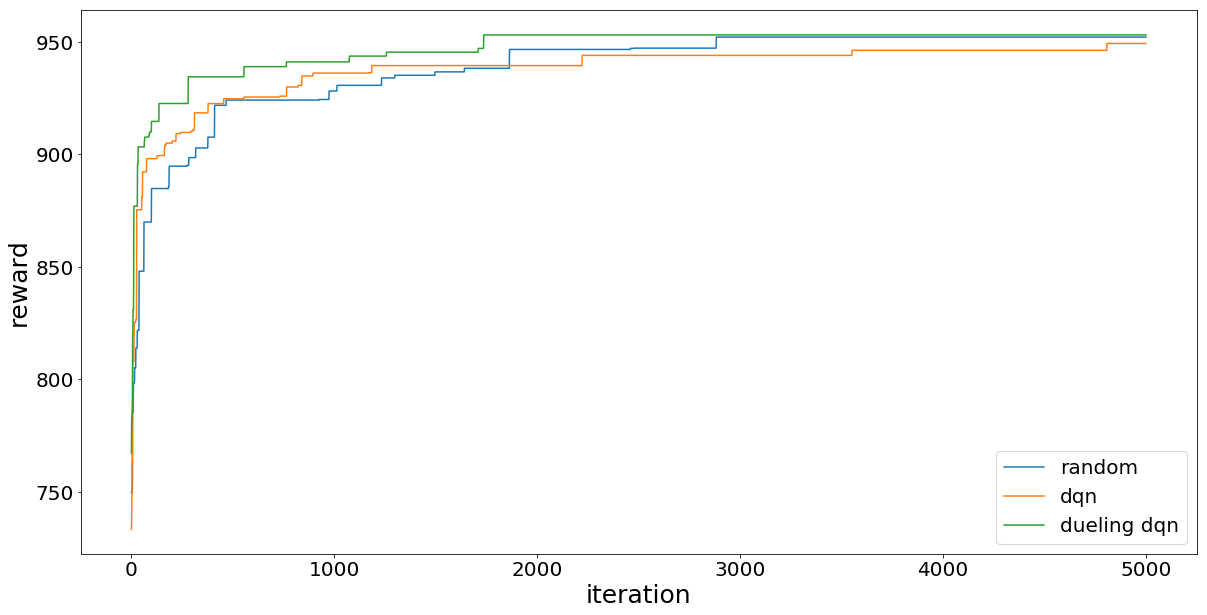

In [50]:
filename_list = ['./experiments/plot/WTA3_random_0.csv',
                 './experiments/plot/WTA3_dqn_0.csv',
                 './experiments/plot/WTA3_dueling-dqn_0.csv']
dataname_list = ['random', 'dqn', 'dueling dqn']
plot_reward(filename_list, dataname_list)

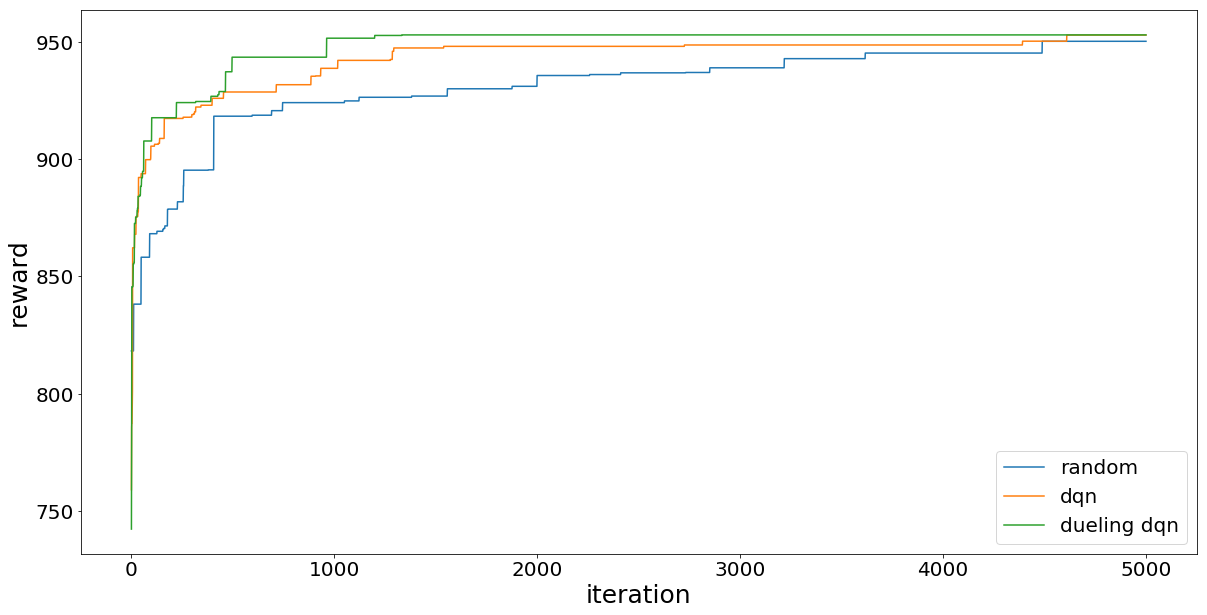

In [53]:
filename_list = ['./experiments/plot/WTA3_random_1.csv',
                 './experiments/plot/WTA3_dqn_1.csv',
                 './experiments/plot/WTA3_dueling-dqn_3.csv']
dataname_list = ['random', 'dqn', 'dueling dqn']
plot_reward(filename_list, dataname_list)

## Only random mutation vs. random +  dqn mutation

## Figures for reward over time for random vs dqn

# Questions

1. What happens if m_m or m_c larger than 1 - not much difference for WTA1 and WTA2
2. Look into what happens when the program hits maximum iter
3. Choose one m_population and m_offsprings and increase max_iter
4. Compare using the same number of convergence instead of until it reaches convergence